# Introduction

This notebook analyzes data collected from a French Bakery (dataset available on kaggle). The dataset provides the daily transaction details of customers from 2021-01-01 to 2022-09-30.

Key Questions:
- What is the profile of sales during the day? the week? the year?
- How do different scenarios impact the likelihood of accepting a coupon?
- Focus on Bar coupon and Coffee House coupon

Let's delve into the data exploration and analysis to uncover insights into driver behavior regarding coupon acceptance.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from matplotlib.colors import to_hex
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose, STL, MSTL

# Data loading and overview 

In [3]:
data = pd.read_csv('data/Bakery sales.csv')

In [4]:
data

,Unnamed: 0,date,time,ticket_number,article,Quantity,unit_price
0,0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,"0,90 €"
1,1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,"1,20 €"
2,4,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,"1,20 €"
3,5,2021-01-02,09:14,150041.0,PAIN,1.0,"1,15 €"
4,8,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,"1,20 €"
...,...,...,...,...,...,...,...
234000,511387,2022-09-30,18:52,288911.0,COUPE,1.0,"0,15 €"
234001,511388,2022-09-30,18:52,288911.0,BOULE 200G,1.0,"1,20 €"
234002,511389,2022-09-30,18:52,288911.0,COUPE,2.0,"0,15 €"
234003,511392,2022-09-30,18:55,288912.0,TRADITIONAL BAGUETTE,1.0,"1,30 €"


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234005 entries, 0 to 234004
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     234005 non-null  int64  
 1   date           234005 non-null  object 
 2   time           234005 non-null  object 
 3   ticket_number  234005 non-null  float64
 4   article        234005 non-null  object 
 5   Quantity       234005 non-null  float64
 6   unit_price     234005 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 12.5+ MB


In [6]:
#checking the different values of columns to see any problematic data
data['article'].value_counts()

article
TRADITIONAL BAGUETTE        67689
COUPE                       20470
BAGUETTE                    15292
BANETTE                     15130
CROISSANT                   11508
                            ...  
PAIN NOIR                       1
BUCHE 8PERS                     1
CRUMBLECARAMEL OU PISTAE        1
DOUCEUR D HIVER                 1
SACHET DE VIENNOISERIE          1
Name: count, Length: 149, dtype: int64

In [7]:
# Count missing values in each column
missing_data_count = data.isnull().sum()
print(missing_data_count)

Unnamed: 0       0
date             0
time             0
ticket_number    0
article          0
Quantity         0
unit_price       0
dtype: int64


# Data cleaning & Preprocessing

There is 234005 entries

In [8]:
# deletion of the useless column car
data = data.drop('Unnamed: 0', axis=1)

In [9]:
# Remove '€' and replace ',' with '.'
data['unit_price'] = data['unit_price'].str.replace('€', '').str.replace(',', '.')

# Convert to numeric
data['unit_price'] = pd.to_numeric(data['unit_price'])

In [10]:
# Remove rows where price is 0 
data = data.query('unit_price != 0 ')

In [11]:
# Convert 'time' to datetime
data['date'] = pd.to_datetime(data['date'])
data['time'] = pd.to_datetime(data['time'], format='%H:%M')

# Add weekday 
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data['weekday'] = data['date'].dt.day_name()
data['weekday'] = pd.Categorical(data['weekday'], categories=weekday_order, ordered=True)

# Add month 
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
data['month'] = data['date'].dt.month_name()
data['month'] = pd.Categorical(data['month'], categories=month_order, ordered=True)


In [12]:
# Total price
data['total_price'] = data['unit_price']*data['Quantity']

In [13]:
# Removing of duplicates
data = data.drop_duplicates()

In [14]:
# Removing of the initial transactions and their refund which do not enter in the revenue 
# Selection of all refunds
data_negative = data[data['Quantity'] < 0]
# Dataset for only refund and their associated initial transaction
data_refunds = pd.DataFrame([])

In [15]:
# Initialize data_no_refunds as a copy of the original data
data_no_refunds = data.copy()
attempts_total = []

# this function search for transaction which is the opposite of the target (refund) and remove it from the dataset
def remove_refund_initial_tx(data, data_ref, row):
    attempts = 1
    max_attempts = 200  # Set your desired maximum attempts
    filtered_rows = []
    # Start a while loop to keep trying until a matching row is found or a maximum number of attempts is reached
    while attempts < max_attempts and len(filtered_rows) == 0:
        # Define the condition for filtering rows
        condition = (
            'Quantity == ' +str(-row['Quantity'])+' and '
            +'article == "' +str(row['article']) +'" and '
            +'total_price == ' +str(-row['total_price']) +' and '
            +'ticket_number == ' +str(row['ticket_number'] - attempts)
        )

        # Apply boolean indexing to filter rows
        filtered_rows = data.query(condition)
        filtered_rows['refund_ticket_number'] = row['ticket_number']
        filtered_rows['date_ticket_number'] = row['date']
        filtered_rows['time_ticket_number'] = row['time']
        filtered_rows['type'] = 'initial'
        filtered_rows = filtered_rows.reset_index()
        data_ref = pd.concat([data_ref, filtered_rows])
        attempts_total.append(attempts)
        attempts +=1
    
    if(len(filtered_rows)>1):
        print('problem')
        print(filtered_rows)
    # Update data_no_refunds with the filtered rows
    data_no_refunds = data.query('~ ('+condition+')')  # Exclude the matching rows
    return data_no_refunds, data_ref

# Loop through each refund
for index, row in data_negative.iterrows():
    # Apply remove_refund_initial_tx function to update data_no_refunds
    data_no_refunds, data_refunds = remove_refund_initial_tx(data_no_refunds, data_refunds, row)

# Deletion of the refunds
data_no_refunds = data_no_refunds[data_no_refunds['Quantity']>0]

if (len(data_no_refunds) == (len(data) - 2*len(data_negative))):
    print('Deletion of refunds and initials transactions proceeded with success')
else:
    print('Deletion of refunds and initials transactions Failed')

/var/folders/v0/cgwrln2d111093wl_kp_tcrw0000gn/T/ipykernel_66159/1223419515.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rows['refund_ticket_number'] = row['ticket_number']
/var/folders/v0/cgwrln2d111093wl_kp_tcrw0000gn/T/ipykernel_66159/1223419515.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rows['date_ticket_number'] = row['date']
/var/folders/v0/cgwrln2d111093wl_kp_tcrw0000gn/T/ipykernel_66159/1223419515.py:24: SettingWithCopyWarning: 
A value is trying to be set on a co

Deletion of refunds and initials transactions proceeded with success


In [16]:
# Add categories
category_df = pd.read_csv('data/category.csv')
# Merge the two DataFrames on the 'article' column to add the category column to the datset
cat_data = pd.merge(data_no_refunds, category_df, on='article', how='left')

# Too few sales for these categories to we regroup them together in Other
replacement_dict = {'Miscellaneous': 'Other', 'Candy': 'Other', 'Beverage':'Other'}
cat_data['Category'] = cat_data['Category'].replace(replacement_dict)

# Define the order of categories
category_order = ['Baguette', 'Bread', 'Viennoiserie', 'Savory', 'Pastry', 'Cake & Tart', 'Other']

# Create a CategoricalDtype with the specified order
category_dtype = pd.CategoricalDtype(categories=category_order, ordered=True)

# Apply the CategoricalDtype to the 'Category' column
cat_data['Category'] = cat_data['Category'].astype(category_dtype)

cat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230197 entries, 0 to 230196
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   date           230197 non-null  datetime64[ns]
 1   time           230197 non-null  datetime64[ns]
 2   ticket_number  230197 non-null  float64       
 3   article        230197 non-null  object        
 4   Quantity       230197 non-null  float64       
 5   unit_price     230197 non-null  float64       
 6   weekday        230197 non-null  category      
 7   month          230197 non-null  category      
 8   total_price    230197 non-null  float64       
 9   Category       230197 non-null  category      
dtypes: category(3), datetime64[ns](2), float64(4), object(1)
memory usage: 13.0+ MB


Saving the preprocessed data into a new csv

In [17]:
cat_data.to_csv('data/cleaned_sales.csv', index=False)

In [18]:
# Add weather and holidays
extra_df = pd.read_csv('data/extra1.csv')
extra_df['date'] = pd.to_datetime(extra_df['date'])
# Merge the two DataFrames on the 'date' column to add the temperature and holiday columns to the datset
extra_data = pd.merge(cat_data, extra_df, on='date', how='left')
extra_data.head()

,date,time,ticket_number,article,Quantity,unit_price,weekday,month,total_price,Category,Temperature,Holiday
0,2021-01-02,1900-01-01 08:38:00,150040.0,BAGUETTE,1.0,0.90,Saturday,January,0.90,Baguette,2,Regular day
1,2021-01-02,1900-01-01 08:38:00,150040.0,PAIN AU CHOCOLAT,3.0,1.20,Saturday,January,3.60,Viennoiserie,2,Regular day
2,2021-01-02,1900-01-01 09:14:00,150041.0,PAIN AU CHOCOLAT,2.0,1.20,Saturday,January,2.40,Viennoiserie,2,Regular day
3,2021-01-02,1900-01-01 09:14:00,150041.0,PAIN,1.0,1.15,Saturday,January,1.15,Bread,2,Regular day
4,2021-01-02,1900-01-01 09:25:00,150042.0,TRADITIONAL BAGUETTE,5.0,1.20,Saturday,January,6.00,Baguette,2,Regular day


In [19]:
data_baguette = extra_data[extra_data['article']=='BAGUETTE']
data_baguette.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15147 entries, 0 to 230108
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           15147 non-null  datetime64[ns]
 1   time           15147 non-null  datetime64[ns]
 2   ticket_number  15147 non-null  float64       
 3   article        15147 non-null  object        
 4   Quantity       15147 non-null  float64       
 5   unit_price     15147 non-null  float64       
 6   weekday        15147 non-null  category      
 7   month          15147 non-null  category      
 8   total_price    15147 non-null  float64       
 9   Category       15147 non-null  category      
 10  Temperature    15147 non-null  int64         
 11  Holiday        15147 non-null  object        
dtypes: category(3), datetime64[ns](2), float64(4), int64(1), object(2)
memory usage: 1.2+ MB


In [20]:
# Aggregate the number of baguettes sold per day
baguette_by_day = data_baguette.groupby('date').agg({
    'Quantity': 'sum',         
    'weekday': 'first',        
    'month': 'first',          
    'Temperature': 'first',    
    'Holiday': 'first'         
})

# One-hot encode 'Holiday'
baguette_by_day_encoded = pd.get_dummies(baguette_by_day, columns=['Holiday'])
baguette_by_day_encoded['Holiday_Holiday'] = baguette_by_day_encoded['Holiday_Holiday'].astype(int)
baguette_by_day_encoded['Holiday_Regular day'] = baguette_by_day_encoded['Holiday_Regular day'].astype(int)
baguette_by_day_encoded['Holiday_School break'] = baguette_by_day_encoded['Holiday_School break'].astype(int)

# Quanitty should be an integer
baguette_by_day_encoded['Quantity'] = baguette_by_day_encoded['Quantity'].astype(int)


In [21]:
baguette_by_day.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 600 entries, 2021-01-02 to 2022-09-30
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Quantity     600 non-null    float64 
 1   weekday      600 non-null    category
 2   month        600 non-null    category
 3   Temperature  600 non-null    int64   
 4   Holiday      600 non-null    object  
dtypes: category(2), float64(1), int64(1), object(1)
memory usage: 20.7+ KB


In [22]:
baguette_by_day_encoded.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 600 entries, 2021-01-02 to 2022-09-30
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Quantity              600 non-null    int64   
 1   weekday               600 non-null    category
 2   month                 600 non-null    category
 3   Temperature           600 non-null    int64   
 4   Holiday_Holiday       600 non-null    int64   
 5   Holiday_Regular day   600 non-null    int64   
 6   Holiday_School break  600 non-null    int64   
dtypes: category(2), int64(5)
memory usage: 30.0 KB


# How many baguettes will be sold ? 

## Exploration

/Users/baha/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x1000 with 0 Axes>

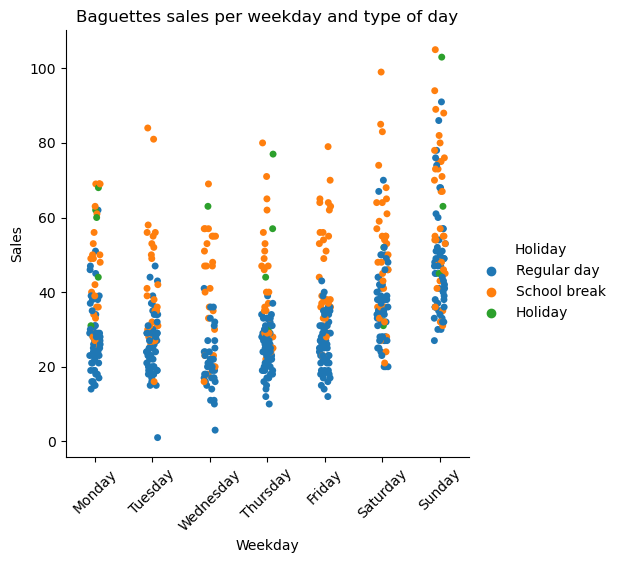

In [23]:
# Generate the catplot with temperature and holiday type as hue, and temperature as size
plt.figure(figsize=(12, 10))

# Plot the combined data with different colors for each category and temperature as size
sns.catplot(data=baguette_by_day, x='weekday', y='Quantity', hue='Holiday')

# Set labels and rotate x-axis labels
plt.title('Baguettes sales per weekday and type of day')
plt.ylabel('Sales')
plt.xlabel('Weekday')
plt.xticks(rotation=45)

# Show the plot
plt.savefig('images/baguetteByWeekdayProfile.png', bbox_inches='tight', transparent=True)
plt.show()

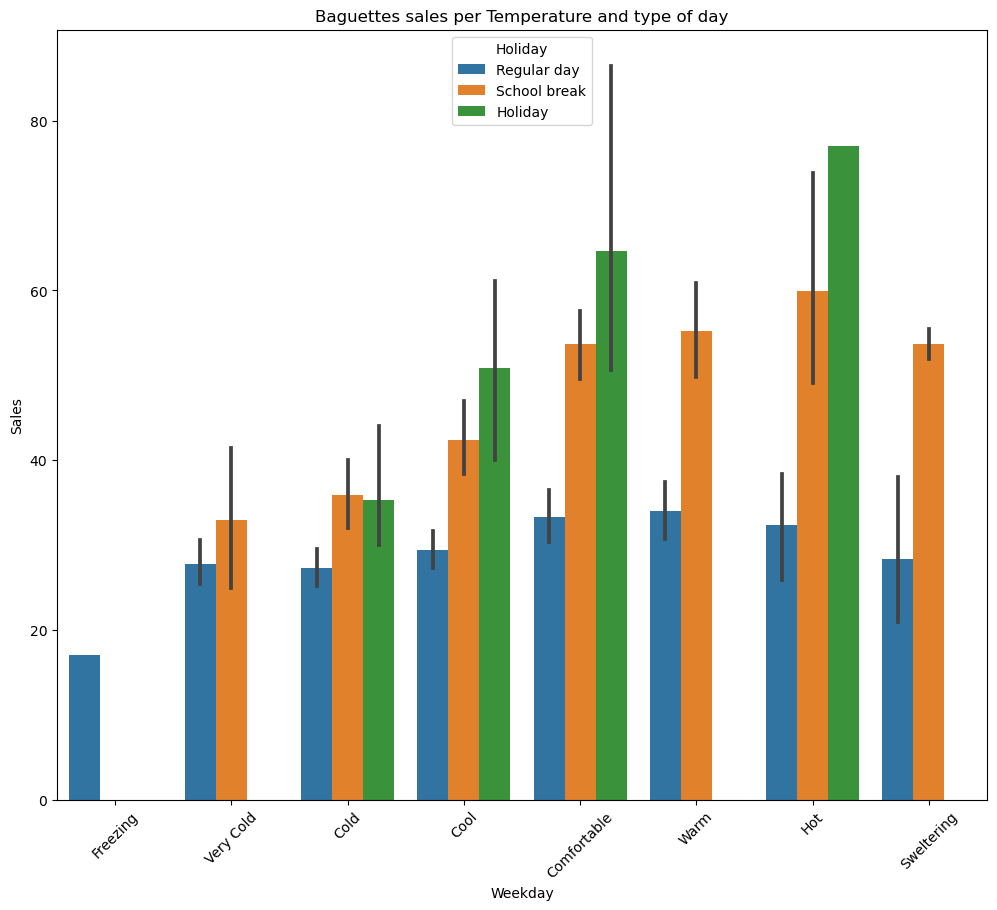

In [27]:
# Generate the catplot with temperature and holiday type as hue, and temperature as size
plt.figure(figsize=(12, 10))

# Plot the combined data with different colors for each category and temperature as size
sns.barplot(data=baguette_by_day, x='Temperature', y='Quantity', hue='Holiday')

# Set labels and rotate x-axis labels
plt.title('Baguettes sales per Temperature and type of day')
plt.ylabel('Sales')
plt.xlabel('Weekday')
temp_labels = ['Freezing', 'Very Cold', 'Cold', 'Cool', 'Comfortable', 'Warm', 'Hot', 'Sweltering']
plt.xticks(ticks=range(8), labels=temp_labels, rotation=45)

# Show the plot
plt.savefig('images/baguetteByTemperatureProfile.png', bbox_inches='tight', transparent=True)
plt.show()

## Analysis

### Decomposition

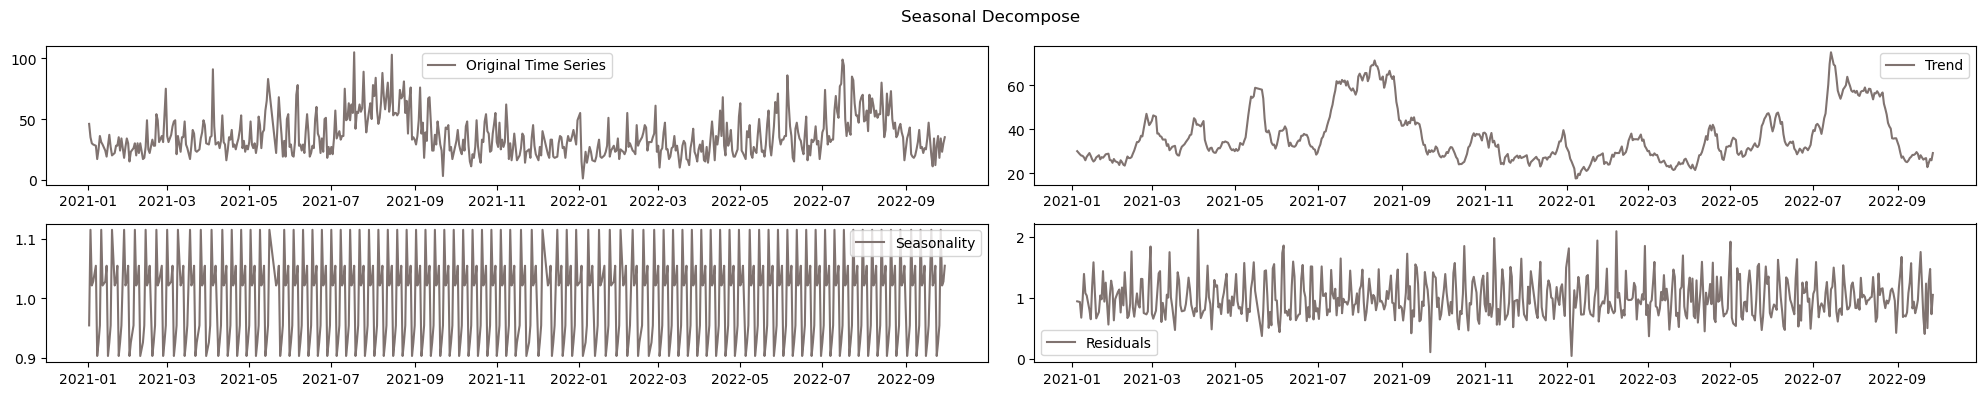

In [192]:
decompose = seasonal_decompose(baguette_by_day[['Quantity']],period=7, model='multiplicative')

# Plot the original time series, trend, and seasonality
plt.figure(figsize=(20, 4))
plt.suptitle('Seasonal Decompose')

plt.subplot(2, 2, 1)
plt.plot(baguette_by_day['Quantity'], label='Original Time Series')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(decompose.trend, label='Trend')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(decompose.seasonal, label='Seasonality')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(decompose.resid, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()

The decomposition with seasonal_decompose doesn't have a smooth trend because we can't describe both seasonalities (weekly, and yearly)

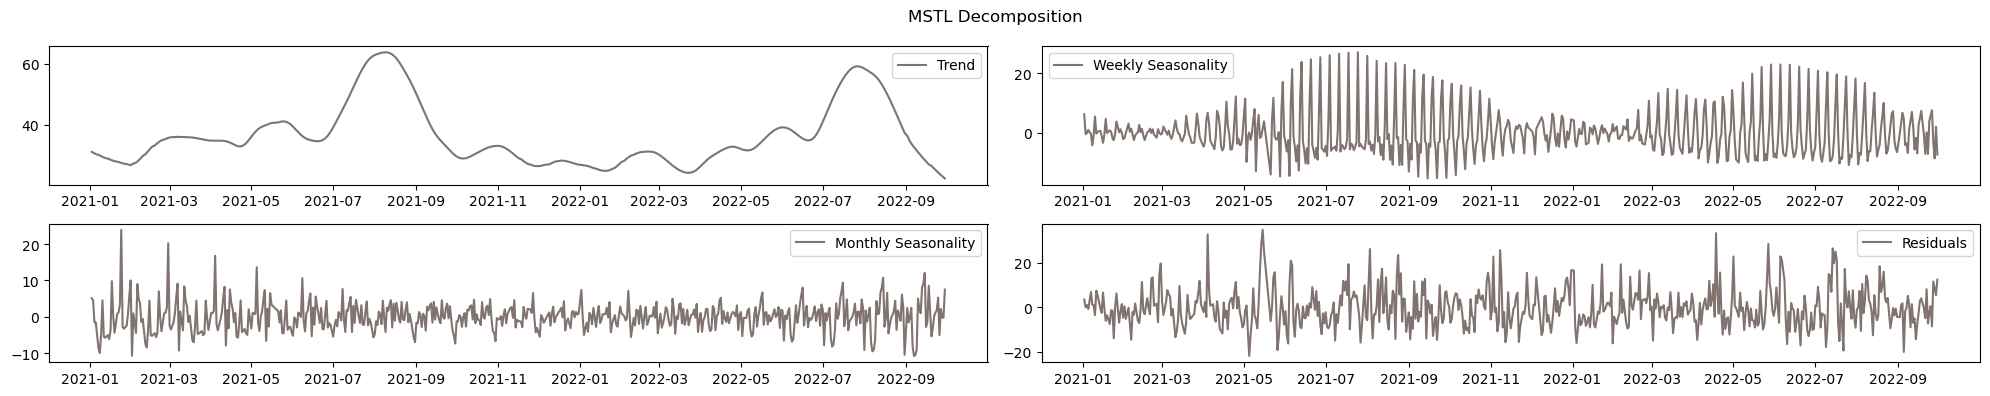

In [199]:
# Perform MSTL decomposition
decompose = MSTL(baguette_by_day['Quantity'], periods=(7, 30)).fit()

# Plot the original time series, trend, and seasonality
plt.figure(figsize=(20, 4))
plt.suptitle('MSTL Decomposition')

plt.subplot(2, 2, 1)
plt.plot(decompose.trend, label='Trend')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(decompose.seasonal.seasonal_7, label='Weekly Seasonality')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(decompose.seasonal.seasonal_30, label='Monthly Seasonality')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(decompose.resid, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()

Trying with MSTL, we cannot observe a yearly seasonality like it should be, I think because we don't have enough data. So I did it with both week and month seasonalities.

On the first decomposition, we can observe a clear weekly seasonality (more sales during the weekend).
We can also observe a smooth trend along the year where the summer months are busier.
  

### Stationarity

In [200]:
#adfuller to check stationarity
pval = adfuller(y_hist)[1]
print(f'The p-value is {pval: .4f}')

adfuller(y_hist)

The p-value is  0.0383


(-2.965046648182451,
 0.03829005884016109,
 14,
 585,
 {'1%': -3.4415777369651717,
  '5%': -2.866493255736561,
  '10%': -2.569407951640003},
 4558.450191698475)

The data is stationary

### Autocorrelation plots

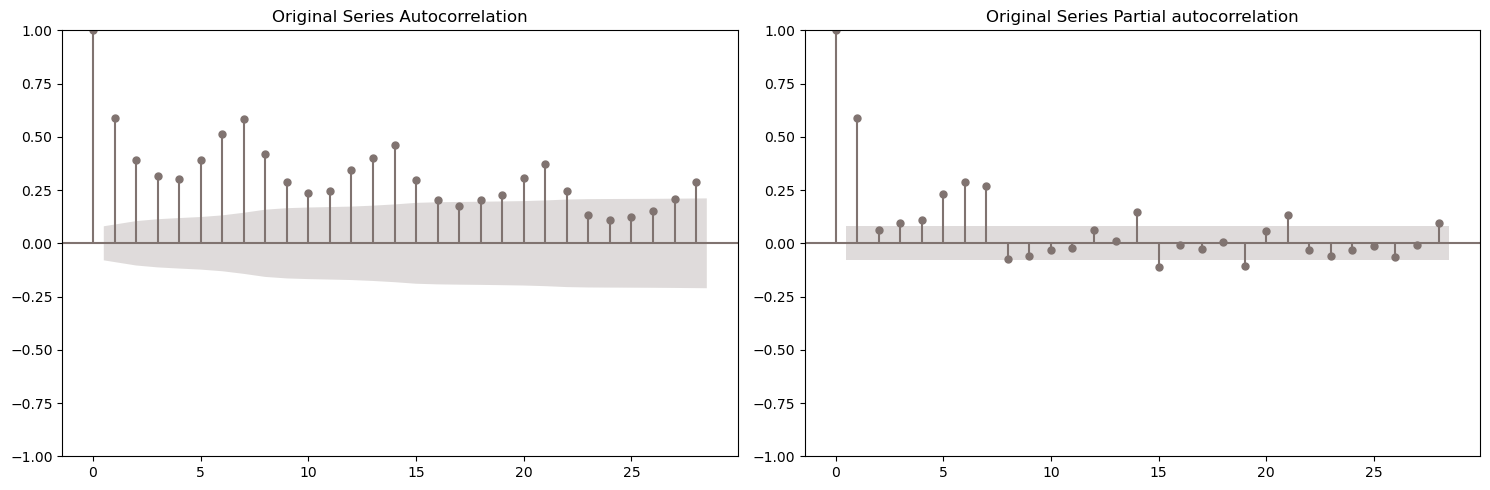

In [97]:
#Autocorrelation plots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Original Series Autocorrelation
plot_acf(y_hist['Quantity'], ax=ax[0])
ax[0].set_title('Original Series Autocorrelation')

# Original Series Partial autocorrelation
plot_pacf(y_hist['Quantity'], ax=ax[1], method='ywm')
ax[1].set_title('Original Series Partial autocorrelation')

plt.tight_layout()
plt.show()

## Modelization
### Split Train/Test set

(572, 7)
(28, 7)


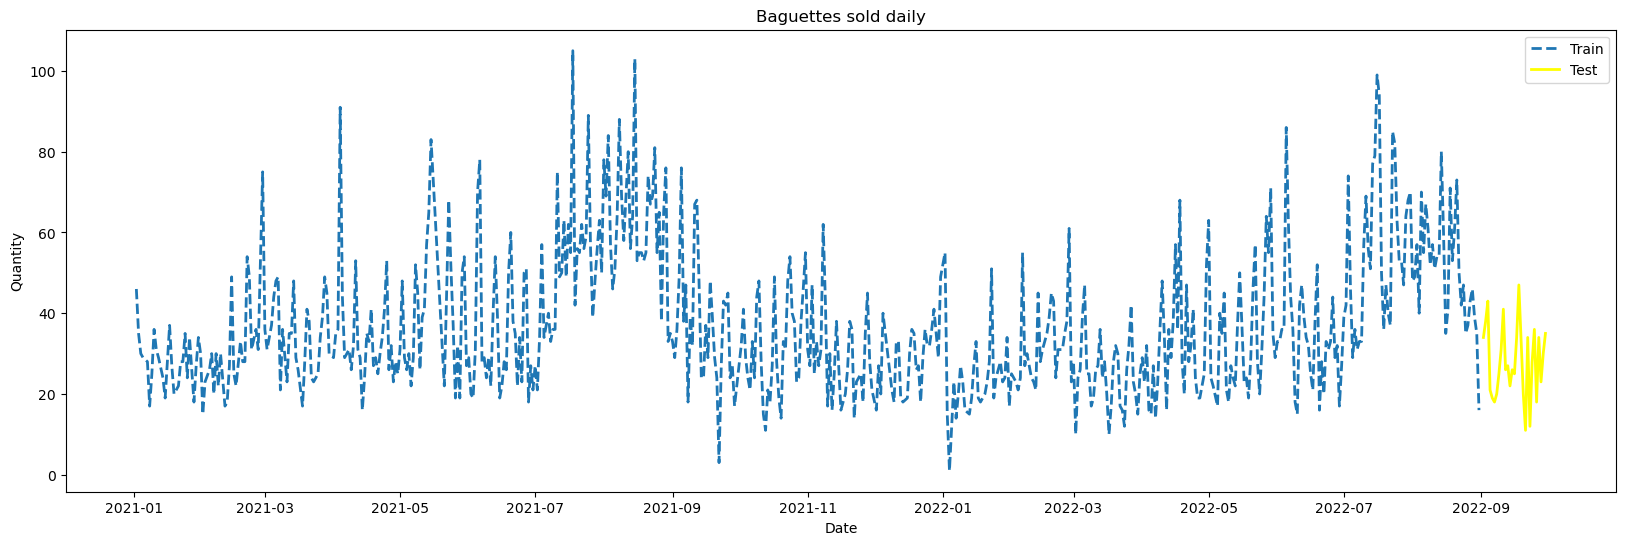

In [36]:
train = baguette_by_day_encoded[baguette_by_day_encoded.index <= '2022-09-01'] 
test = baguette_by_day_encoded[baguette_by_day_encoded.index > '2022-09-01']
print(train.shape)
print(test.shape)
plt.figure(figsize=(20, 6))
sns.lineplot(train, x=train.index, y="Quantity", label="Train", linestyle="--",linewidth=2)
sns.lineplot(test, x=test.index, y="Quantity", label="Test", linewidth=2, color="yellow")
plt.title("Baguettes sold daily");
plt.xlabel("Date")
plt.show()

### Model ARIMA

In [37]:
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(arima_order):
	# Create Model and fit to train data
	model = ARIMA(train['Quantity'], order=arima_order)
	fitted_model = model.fit()

	# Make predictions on test data
	start_index = len(train)
	end_index = start_index + len(test) - 1
	predictions = fitted_model.predict(start=start_index, end=end_index, dynamic=True)

	# Calculate test error
	mse = mean_squared_error(test['Quantity'], predictions)
	return mse
 
# evaluate parameters
p_values = [0, 2, 4, 8, 10, 12]
d_values = range(0, 3)
q_values = range(0, 3)
best_score, best_cfg = float("inf"), None
for p in p_values:
	for d in d_values:
		for q in q_values:
			try:
				order = (p,d,q)
				mse = evaluate_arima_model(order)
				if mse < best_score:
					best_score, best_cfg = mse, order
				print('ARIMA%s MSE=%.3f' % (order,mse))
			except Exception as e:
				print(e)
				continue
print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

ARIMA(0, 0, 0) MSE=167.252
ARIMA(0, 0, 1) MSE=168.375
ARIMA(0, 0, 2) MSE=170.217
ARIMA(0, 1, 0) MSE=218.000
ARIMA(0, 1, 1) MSE=183.371
ARIMA(0, 1, 2) MSE=275.249
ARIMA(0, 2, 0) MSE=105986.929
ARIMA(0, 2, 1) MSE=236.682
ARIMA(0, 2, 2) MSE=183.282
ARIMA(2, 0, 0) MSE=165.445
ARIMA(2, 0, 1) MSE=217.647
ARIMA(2, 0, 2) MSE=210.049
ARIMA(2, 1, 0) MSE=98.932
ARIMA(2, 1, 1) MSE=258.030
ARIMA(2, 1, 2) MSE=110.227
ARIMA(2, 2, 0) MSE=39920.411
ARIMA(2, 2, 1) MSE=103.557
ARIMA(2, 2, 2) MSE=260.887
ARIMA(4, 0, 0) MSE=151.139
ARIMA(4, 0, 1) MSE=172.965
ARIMA(4, 0, 2) MSE=195.362
ARIMA(4, 1, 0) MSE=81.455
ARIMA(4, 1, 1) MSE=148.570
ARIMA(4, 1, 2) MSE=88.925
ARIMA(4, 2, 0) MSE=15778.515
ARIMA(4, 2, 1) MSE=80.370
ARIMA(4, 2, 2) MSE=148.525
ARIMA(8, 0, 0) MSE=126.965
ARIMA(8, 0, 1) MSE=121.636
ARIMA(8, 0, 2) MSE=121.635
ARIMA(8, 1, 0) MSE=102.271
ARIMA(8, 1, 1) MSE=101.405
ARIMA(8, 1, 2) MSE=107.871
ARIMA(8, 2, 0) MSE=2315.844
ARIMA(8, 2, 1) MSE=101.815
ARIMA(8, 2, 2) MSE=103.458
ARIMA(10, 0, 0) MSE=121.

### Model SARIMAX - using Temperature and Holiday features

In [38]:

# Define the function to evaluate SARIMAX model for a given order (p,d,q)
def evaluate_sarimax_model(order,seasonal_order):
    history = train['Quantity']
    exog_history = train[['Holiday_Regular day','Holiday_School break', 'Holiday_Holiday', 'Temperature']]
    exog_test = test[['Holiday_Regular day','Holiday_School break', 'Holiday_Holiday', 'Temperature']]

    # Create Model and fit to train data
    model = SARIMAX(history, order=order, seasonal_order=seasonal_order, exog=exog_history)
    fitted_model = model.fit(disp=0)

    # Make predictions on test data
    start_index = len(train)
    end_index = start_index + len(test) - 1
    predictions = fitted_model.predict(start=start_index, end=end_index, dynamic=True, exog=exog_test)

    # Calculate test error
    error = mean_squared_error(test['Quantity'], predictions, squared=False)
    return error

# Define the parameter grid
p_values = [2, 4, 6]
d_values = range(0, 3)
q_values = range(0, 3)
P_values = [0, 1, 2]
D_values = range(0, 3)
Q_values = range(0, 3)

# Perform grid search
best_score, best_cfg = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        order = (p, d, q)
                        seasonal_order = (P, D, Q, 7)  # We set seasonality to 7 for a weekly seasonality
                        try:
                            mse = evaluate_sarimax_model(order, seasonal_order)
                            if mse < best_score:
                                best_score, best_cfg = mse, (order, seasonal_order)
                            print('SARIMAX%s MSE=%.3f' % ((order, seasonal_order), mse))
                        except Exception as e:
                            print(e)
                            continue

print('Best SARIMAX%s MSE=%.3f' % (best_cfg, best_score))

SARIMAX((2, 0, 0), (0, 0, 0, 7)) MSE=11.084
SARIMAX((2, 0, 0), (0, 0, 1, 7)) MSE=10.901
SARIMAX((2, 0, 0), (0, 0, 2, 7)) MSE=9.985
SARIMAX((2, 0, 0), (0, 1, 0, 7)) MSE=12.047
SARIMAX((2, 0, 0), (0, 1, 1, 7)) MSE=14.922
SARIMAX((2, 0, 0), (0, 1, 2, 7)) MSE=14.836
SARIMAX((2, 0, 0), (0, 2, 0, 7)) MSE=70.344
SARIMAX((2, 0, 0), (0, 2, 1, 7)) MSE=12.236
SARIMAX((2, 0, 0), (0, 2, 2, 7)) MSE=15.450
SARIMAX((2, 0, 0), (1, 0, 0, 7)) MSE=10.207
SARIMAX((2, 0, 0), (1, 0, 1, 7)) MSE=11.923
SARIMAX((2, 0, 0), (1, 0, 2, 7)) MSE=11.943
SARIMAX((2, 0, 0), (1, 1, 0, 7)) MSE=11.858
SARIMAX((2, 0, 0), (1, 1, 1, 7)) MSE=14.812
SARIMAX((2, 0, 0), (1, 1, 2, 7)) MSE=12.937
SARIMAX((2, 0, 0), (1, 2, 0, 7)) MSE=34.589
SARIMAX((2, 0, 0), (1, 2, 1, 7)) MSE=11.954
SARIMAX((2, 0, 0), (1, 2, 2, 7)) MSE=15.470
SARIMAX((2, 0, 0), (2, 0, 0, 7)) MSE=9.808
SARIMAX((2, 0, 0), (2, 0, 1, 7)) MSE=11.795
SARIMAX((2, 0, 0), (2, 0, 2, 7)) MSE=12.112
SARIMAX((2, 0, 0), (2, 1, 0, 7)) MSE=13.045
SARIMAX((2, 0, 0), (2, 1, 1, 7)) M

### Other approach - not time analysis
We can process the data withtout taking in account the actual date and consider only the weekday and the month, with a regular regression which can provide us a different vision.

In [28]:
# Encoding the weekday and month with cycling to keep the periodicity
baguette_by_day_no_date = baguette_by_day_encoded.copy()

# Cyclical Encoding for weekday
baguette_by_day_no_date['weekday_sin'] = np.sin(2 * np.pi * baguette_by_day_no_date['weekday'].astype('category').cat.codes / 7)
baguette_by_day_no_date['weekday_cos'] = np.cos(2 * np.pi * baguette_by_day_no_date['weekday'].astype('category').cat.codes / 7)

# Cyclical Encoding for month
baguette_by_day_no_date['month_sin'] = np.sin(2 * np.pi * baguette_by_day_no_date['month'].astype('category').cat.codes / 12)
baguette_by_day_no_date['month_cos'] = np.cos(2 * np.pi * baguette_by_day_no_date['month'].astype('category').cat.codes / 12)

# Drop the original 'weekday' and 'month' columns
baguette_by_day_no_date.drop(['weekday', 'month'], axis=1, inplace=True)

In [29]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# Splitting data into features and target
X = baguette_by_day_no_date.drop('Quantity', axis=1)
y = baguette_by_day_no_date['Quantity']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Creating a pipeline with scaling and a regressor
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Scale data
    ('regressor', LinearRegression())  # Linear regression
])

In [33]:
# Parameters for grid search (example, add parameters suitable for your case)
param_grid = {
    'scaler__with_mean': [True, False],
    'scaler__with_std': [True, False],
    'regressor__fit_intercept': [True, False],
    'regressor__positive': [True, False]
}

# Setting up the grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5)


In [34]:
#Train
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(-grid_search.best_score_))

# Predicting with the best model
y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE: {:.2f}".format(mse))

Best parameters: {'regressor__fit_intercept': False, 'regressor__positive': False, 'scaler__with_mean': False, 'scaler__with_std': True}
Best cross-validation score: -0.50
Test MSE: 144.84
